## Trabalho 1 — INF-0618 Deep Learning   


Alunos:
- Carlos Zerwes Amado Sette
- Igor Alejandro Sousa Santos
- João Pedro Viccari

Neste trabalho, vamos utilizar o conjunto de dados OCTMNist. Este conjunto de dados possui imagens de exames OCT (Tomografia de Coerência Óptica) de retina. Esse exame utiliza luz infravermelha para criar imagens de alta precisão das retinas. Este conjunto de dados faz parte da coleção MedMNIST, uma coleção de conjuntos de dados de imagens médicas disponibilizados no padrão de datasets do MNist (grande quantidade de imagens de baixa e média resolução para problemas de classificação).

O dataset é composto por 109,309 imagens, divididas em 97,477 amostras para treinamento, 10,832 para validação e 1,000 para teste. As imagens têm dimensões de 64 × 64 pixels e são representadas em escala de cinza (1 canal de cor).

O OCTMNist contém 4 classes distintas de doenças na retina, com os seguintes rótulos e respectivas descrições:

- 0: CNV (Choroidal Neovascularization - Neovascularização coroidal é o crescimento anormal de novos vasos sanguíneos que se originam na coroide, uma camada que contém vasos sanguíneos sob a retina, e que se estendem para o espaço subretiniano)
- 1: DME (Diabetic Macular Edema - O Edema Macular Diabético é uma complicação do diabetes que causa inchaço na mácula, a região central da retina, responsável pela visão nítida. A principal causa do EMD é o vazamento de líquidos dos vasos sanguíneos da retina devido à hiperglicemia.)
- 2: Drusen (Drusen - Drusas na retina, ou drusas subretinianas, são depósitos amarelados ou brancos que se formam entre o epitélio pigmentar da retina e a membrana de Bruch, e são uma ocorrência comum com o envelhecimento.)
- 3: Normal  (Sem problemas, ausência de qualquer fluido/edema retiniano)

![Classes do dataset OCTMNist](https://drive.google.com/uc?id=1vB0jsHMlkRZnHgYSbmt6bJg_iyKwWh2n)


## Importando bibliotecas

Todas já estão instaladas no Google Colab. Caso localmente algum import falhe, a biblioteca específica deve ser instalada.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.metrics import balanced_accuracy_score

## Baixar e carregar os dados

Iremos baixar os dados diretamente do link do conjunto de dados.

A próxima célula só precisa ser executada na primeira execução local (e em novas instâncias do Colab).

In [ ]:
# import requests

# url = "https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1"
# response = requests.get(url)

# with open("octmnist_64.npz", "wb") as file:
#     file.write(response.content)

In [ ]:
# # Baixa o conteúdo do link e renomeia para octmnist_64
# !wget https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1 -O octmnist_64.npz

--2025-05-22 18:44:02--  https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311755777 (297M) [application/octet-stream]
Saving to: ‘octmnist_64.npz’

octmnist_64.npz     100%[===================>] 297.31M  12.5MB/s    in 2m 41s  

2025-05-22 18:46:52 (1.85 MB/s) - ‘octmnist_64.npz’ saved [311755777/311755777]



In [ ]:
# # Carrega os dados baixados do MedMNist

# data = np.load('octmnist_64.npz')
# lst = data.files
# print("Chaves disponíveis nos dados carregados: " + ', '.join(lst))

In [ ]:
# # Salvar os arquivos no drive para não precisar baixar todas as vezes em que abrir o notebook
# from google.colab import drive
# drive.mount('/content/drive')

# !mv octmnist_64.npz /content/drive/MyDrive/

In [3]:
# Carrega os arquivos

data = np.load('octmnist_64.npz')
lst = data.files
print("Chaves disponíveis nos dados carregados: " + ', '.join(lst))

Chaves disponíveis nos dados carregados: train_images, train_labels, val_images, val_labels, test_images, test_labels


In [ ]:
data['train_images'][0] # No Colab a imagem será mostrada!

array([[20, 24, 25, ..., 27, 22, 22],
       [16, 27, 22, ..., 25, 28, 28],
       [22, 23, 21, ..., 22, 30, 19],
       ...,
       [ 9, 10, 12, ..., 17, 17, 17],
       [ 9, 10, 10, ..., 12, 12, 16],
       [ 8,  9,  8, ..., 10,  9, 10]], dtype=uint8)

In [4]:
# Aqui também iremos definir os nomes das classes para as visualizações futuras.
# As classes são numeradas nesta ordem de 0 a 3, portanto sendo o índice que corresponde à sua definição
class_names = ['CNV', 'DME', 'Drusen', 'normal']

## Dividir os dados

In [5]:
# Preparar os dados do OCTMNIST
def Prepare_oct_mnist(images, size=64):
  '''
  Função para preparar os dados.
  Aqui iremos mudar o tamanho da imagem (original é 64x64), normalizar e
  colocar os dados no formato necessário para treinamento.
  '''
  images = tf.convert_to_tensor(images)
  # Adiciona um canal para ficar no formato esperado pelo tensorflow (batch, altura, largura, canais)
  images = tf.expand_dims(images, axis=-1)         # (N, 64, 64, 1)
  # Redimensionar imagens
  images = tf.image.resize(images, [size, size])   # (N, size, size, 1)

  # Aplicar normalização
  images = (tf.cast(images, tf.float32) - 0.5) / 0.5  # Normalizar entre [-1, 1]

  return images.numpy()

# Carregar os conjuntos de treino, validação e teste
# Usaremos o .flatten() para transformar as labels desse formato => array([[0],[3],[3],...])
# para este => array([0, 3, 3, ..., 0, 3, 0])
X_train, y_train = Prepare_oct_mnist(data['train_images'], size=64), data['train_labels'].flatten()
X_val, y_val = Prepare_oct_mnist(data['val_images'], size=64), data['val_labels'].flatten()
X_test, y_test = Prepare_oct_mnist(data['test_images'], size=64), data['test_labels'].flatten()

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(97477, 64, 64, 1)
(10832, 64, 64, 1)
(97477,)
(10832,)


## Funções Auxiliares

In [6]:
from sklearn import metrics, datasets
import seaborn as sns

def  plot_loss_accuracy():
  history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  pass

def plot_confusion_matrix(valid, p_valid, tag="Modelo"):
    # Criando a matriz de confusão
    c = metrics.confusion_matrix(valid, p_valid)

    # Normalizando a matriz para obter valores relativos
    c_relative = c.astype('float') / c.sum(axis=1, keepdims=True)

    # Criando o gráfico
    plt.figure(figsize=(6, 6))
    plt.suptitle(f'Matriz de confusão relativa - {tag}', fontsize=20)
    sns.heatmap(c_relative, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".2f", cbar=True)

    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Real")
    plt.show()

def plot_loss_accuracy_2(history, tag):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.title('model accuracy: ', tag)
  plt.suptitle(f'Gráfico de acurácia - {tag}', fontsize=20)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  pass

In [ ]:
def plotImages(imgList, labels=None, n_row=1, n_col=1, figsize=(7, 5)):
    """
    Visualiza uma lista de imagens. Caso 'labels' seja diferente de None, mostra
    os rótulos de cada imagem.

    Parameters:
    - imgList: lista de imagens (arrays)
    - labels: opcional, lista de inteiros (respectivas classes)
    - n_row, n_col: quantidade de linhas de imagens e quantidade de imagens por coluna
    - figsize: tamanho da figura total
    """
    fig, axs = plt.subplots(n_row, n_col, figsize=figsize)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

    for i, (img, ax) in enumerate(zip(imgList, axs)):
      ax.imshow(np.uint8(img), cmap='gray')
      if labels is not None and i < len(labels):
        label_idx = labels[i]
        if 0 <= label_idx < len(class_names):
          ax.set_title(class_names[label_idx])
      ax.axis('off')

    for ax in axs[len(imgList):]:  # Remove x e y dos subplots não utilizados
      ax.axis('off')

    plt.tight_layout()
    plt.show()

### Visualização dos dados

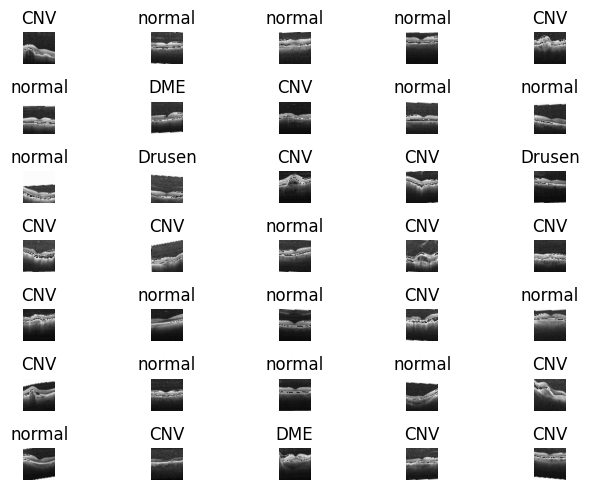

In [ ]:
n = 35
x = X_train[:n]

plotImages(x, n_row=n//5, n_col=5, labels=y_train[:n])


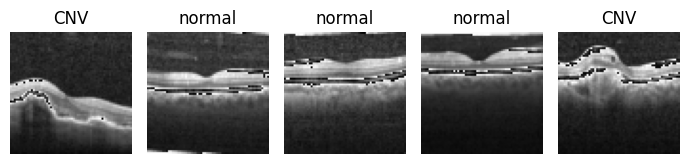

In [ ]:
# Quando plotamos as imagens em tamanho muito maior que o original, alguns artefatos aparecem
n = 5
x = X_train[:n]

plotImages(x, n_row=n//5, n_col=5, labels=y_train[:n])


## Atividade

Para cada questão proposta, descreva detalhadamente os experimentos realizados e apresente uma análise aprofundada dos resultados obtidos. É essencial criar gráficos que mostrem a relação entre a função de perda loss e o número de épocas, considerando os dados de treinamento e de validação para cada modelo. Além disso, apresente a matriz de confusão em termos relativos. Identificar sinais de  overfitting é crucial para avaliar a capacidade de generalização do modelo; portanto, baseando-se nos gráficos elaborados, discuta quaisquer indícios que possam sugerir que o modelo está se ajustando excessivamente aos dados de treinamento

Nota Importante: O conjunto de teste deve ser utilizado apenas uma vez, no final de todas as experimentações!

### Projeção e Treinamento de uma Rede Neural Convolucional Simples (Baseline)

1. (1.5) Projete e treine uma rede neural convolucional simples como modelo básico (baseline), construindo-a do zero sem utilizar arquiteturas pré-existentes. Por exemplo, você pode iniciar com uma arquitetura que contenha apenas algumas camadas convolucionais e de pooling. Lembre-se: quanto mais simples for a arquitetura inicial, melhor será para avaliar o impacto de futuras melhorias.

In [ ]:
# Definir modelo baseline
model = keras.Sequential([
    # Primeira camada convolucional
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2,2)),

    # Segunda camada convolucional
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Flatten antes da camada densa
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(set(y_train)), activation='softmax')  # Softmax para classificação
])

# Compilar modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumo da arquitetura
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,092 (6.20 MB)

 Trainable params: 1,625,092 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Treinar a rede
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    batch_size=8)


Epoch 1/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.6523 - loss: 1.5537 - val_accuracy: 0.8696 - val_loss: 0.4022
Epoch 2/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.8800 - loss: 0.3553 - val_accuracy: 0.8817 - val_loss: 0.3789
Epoch 3/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9068 - loss: 0.2830 - val_accuracy: 0.9042 - val_loss: 0.3170
Epoch 4/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.9207 - loss: 0.2394 - val_accuracy: 0.9077 - val_loss: 0.3076
Epoch 5/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.9309 - loss: 0.2114 - val_accuracy: 0.8994 - val_loss: 0.3322
Epoch 6/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9363 - loss: 0.1967 - val_accuracy: 0.9076 - val_loss: 0.3421
Epoch 7/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9361 - loss: 0.2022 - val_accuracy: 0.9051 - val_loss: 0.3961
Epoch 8/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 

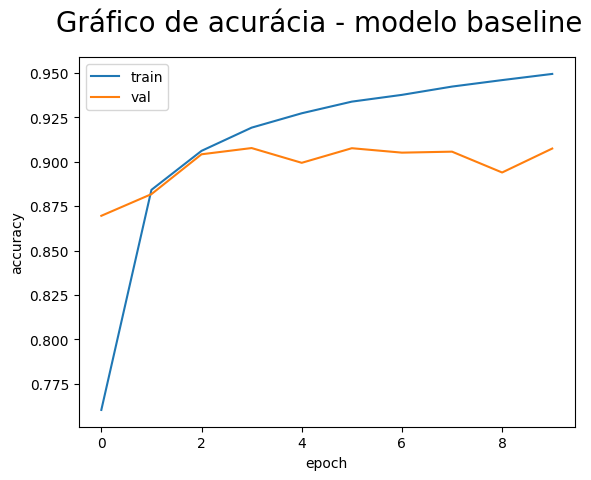

In [ ]:
plot_loss_accuracy_2(history, "modelo baseline")

339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


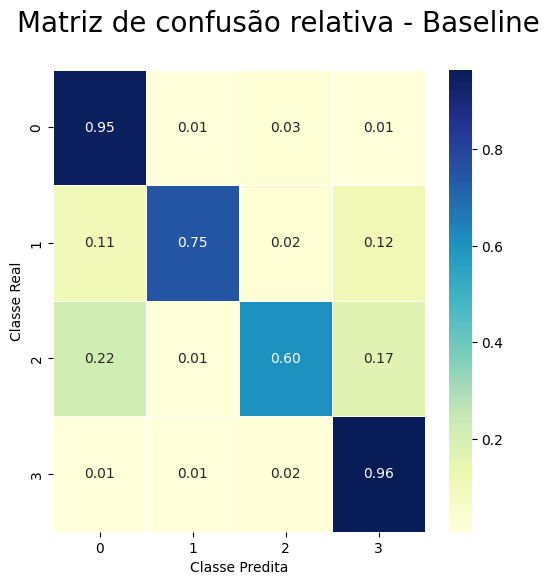

In [ ]:
# imprimir matriz de confusão relativa
plot_confusion_matrix(y_val, np.argmax(model.predict(X_val), axis=1), tag="Baseline")

In [ ]:
# calcular acurácia balanceada para base model
from sklearn.metrics import balanced_accuracy_score

# Fazer previsões no conjunto de validação
y_pred = model_baseline.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades para classes previstas

# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(y_val, y_pred_classes)

print(f"Acurácia Balanceada para Base Model: {balanced_acc:.4f}")


339/339 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Acurácia Balanceada para Base Model: 0.8164


#### Salvar modelo

In [ ]:
# Salvar o modelo baseline
import pickle

model.save('/content/drive/MyDrive/Deep Learning/model_baseline.keras')

# Salvar histórico de treinamento
with open('/content/drive/MyDrive/Deep Learning/historico_treinamento.pkl', 'wb') as f:
    pickle.dump(history.history, f)

#### Carregar modelo

In [ ]:
# Carregar os arquivos do drive para não precisar baixar todas as vezes em que abrir o notebook
# from google.colab import drive
# drive.mount('/content/drive')

### as linhas comentadas sao para carregar os arquivos do drive
# # !mv octmnist_64.npz /content/drive/MyDrive/
# # Carregar modelo treinado
# model = tf.keras.models.load_model('/content/drive/MyDrive/Deep Learning/model_baseline.keras')

# # Carregar histórico de treinamento
# with open('/content/drive/MyDrive/Deep Learning/historico_treinamento.pkl', 'rb') as f:
#     history = pickle.load(f)

model_baseline = tf.keras.models.load_model('model_baseline.keras')

Discussão:

O modelo baseline contou com duas camadas convolucionais simples e duas de max pooling 2D.

Vemos que o modelo baseline obteve 95% de acurácia para 10 épocas, entretanto, o gráfico exibe um comportamento de overfitting para epocas maiores que 2. Podemos prosseguir com algumas alterações, como aplicação de dropout e regularizações, ou mesmo acrescentar mais camadas.

Já na matriz de confusão, vemos que, no geral, tivemos boas acurácias para as classes, exceto para classe 2 (Drusen) que obreve uma acurácia de 52%. Sugere-se aumentar o número de camadas para capturar mais detalhes da classe 2.


### Variação do Número de Camadas de Convolução e Pooling

2. (1.5) Explore o impacto de variar o número de camadas de convolução e pooling em duas arquiteturas diferentes em relação ao modelo baseline. Ao construir essas arquiteturas, experimente diferentes funções de ativação, inicializações e regularizações, e considere o uso de dropout na camada totalmente conectada. Visite http://keras.io para descobrir quais funções de ativação e outros componentes estão disponíveis. Não se esqueça de plotar os gráficos da função de perda loss em relação ao número de épocas, tanto para o treino quanto para a validação de cada modelo. Tenha cuidado com o overfitting.


### model_1

In [ ]:
# vamos testar com o model_1 (alteração do baseline) adicionando mais camadas convolucionais somente.
# Vamos incluir he_normal como inicializador para melhorar a convergência

model_1 = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu'),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(set(y_train)), activation='softmax')  # Softmax para classificação
])

model_1.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Resumo da arquitetura
model_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,437,700 (5.48 MB)

 Trainable params: 1,437,700 (5.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Treinar a rede
history_1 = model_1.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    batch_size=8)


Epoch 1/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.7932 - loss: 1.1842 - val_accuracy: 0.9002 - val_loss: 0.3608
Epoch 2/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9016 - loss: 0.3123 - val_accuracy: 0.9018 - val_loss: 0.3366
Epoch 3/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.9112 - loss: 0.2815 - val_accuracy: 0.8937 - val_loss: 0.3325
Epoch 4/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.9173 - loss: 0.2667 - val_accuracy: 0.9183 - val_loss: 0.2585
Epoch 5/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9206 - loss: 0.2577 - val_accuracy: 0.9251 - val_loss: 0.2364
Epoch 6/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9208 - loss: 0.2700 - val_accuracy: 0.9228 - val_loss: 0.2502
Epoch 7/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9236 - loss: 0.2452 - val_accuracy: 0.9258 - val_loss: 0.2430
Epoch 8/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 

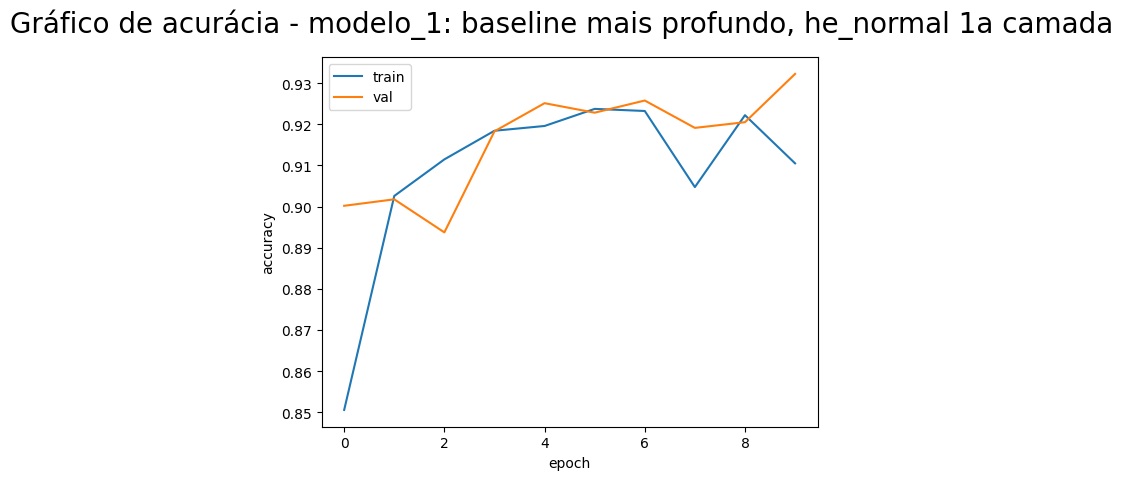

In [ ]:
plot_loss_accuracy_2(history_1, "modelo_1: baseline mais profundo, he_normal 1a camada")

339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


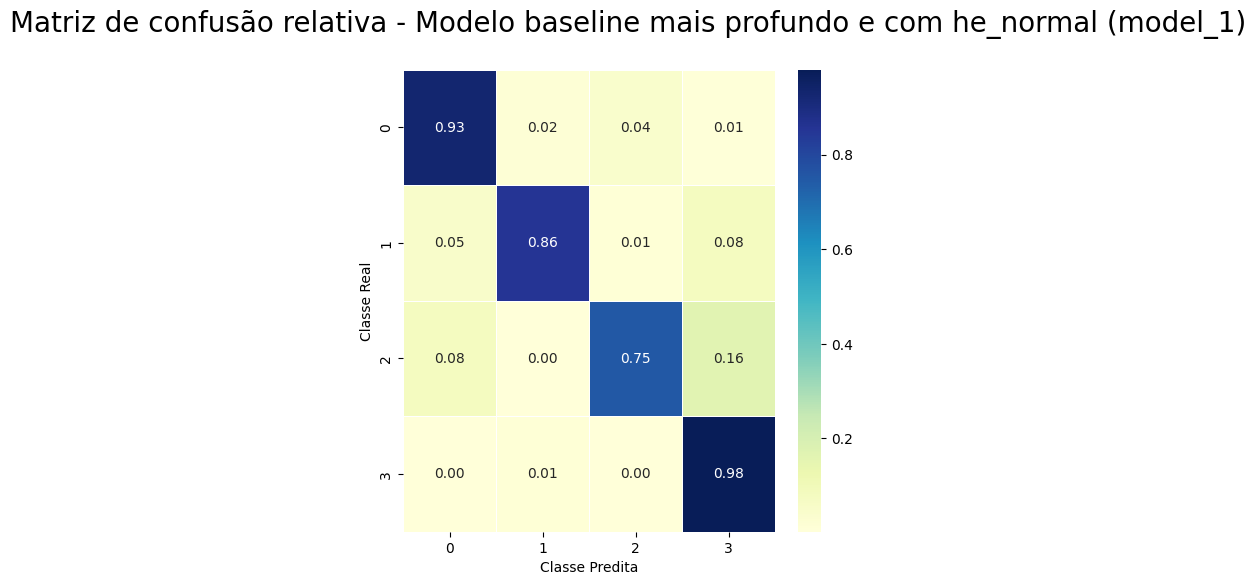

In [ ]:
# imprimir matriz de confusão relativa
plot_confusion_matrix(y_val, np.argmax(model_1.predict(X_val), axis=1), tag="Modelo baseline mais profundo e com he_normal (model_1)")

In [ ]:
# calcular acurácia balanceada para model_1

# Fazer previsões no conjunto de validação
y_pred = model_1.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades para classes previstas

# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(y_val, y_pred_classes)

print(f"Acurácia Balanceada para model_1: {balanced_acc:.4f}")

339/339 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
Acurácia Balanceada para model_1: 0.8799


In [ ]:
# Salvar o modelo
model_1.save('/content/drive/MyDrive/Deep Learning/model_1.keras')

# Salvar histórico de treinamento
with open('/content/drive/MyDrive/Deep Learning/historico_model_1.pkl', 'wb') as f:
    pickle.dump(history_1.history, f)

In [ ]:
# # Carregar modelo treinado DRIVE
# model_1 = tf.keras.models.load_model('/content/drive/MyDrive/Deep Learning/model_1.keras')

# # Carregar histórico de treinamento
# with open('/content/drive/MyDrive/Deep Learning/historico_model_1.pkl', 'rb') as f:
#     history_1 = pickle.load(f)

model_1 = tf.keras.models.load_model('model_1.keras')

### model_2


In [ ]:
# O model_2 será o model_1 com adição de regularização l2 e dropout na camada totalmente conectada.
model_2 = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                  kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.001)),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Adicionando dropout com taxa de 50%
    layers.Dense(len(set(y_train)), activation='softmax')  # Softmax para classificação
])

# Compilar o modelo corretamente
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Resumo da arquitetura
model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,437,700 (5.48 MB)

 Trainable params: 1,437,700 (5.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Treinar a rede
history_2 = model_2.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    batch_size=8)


Epoch 1/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.7459 - loss: 1.9499 - val_accuracy: 0.8644 - val_loss: 0.5678
Epoch 2/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - accuracy: 0.8750 - loss: 0.5206 - val_accuracy: 0.9112 - val_loss: 0.3798
Epoch 3/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 0.8958 - loss: 0.4242 - val_accuracy: 0.8751 - val_loss: 0.4592
Epoch 4/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.8980 - loss: 0.3994 - val_accuracy: 0.9035 - val_loss: 0.3930
Epoch 5/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.9012 - loss: 0.3889 - val_accuracy: 0.9128 - val_loss: 0.3468
Epoch 6/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.9040 - loss: 0.3762 - val_accuracy: 0.9090 - val_loss: 0.3508
Epoch 7/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9038 - loss: 0.3759 - val_accuracy: 0.9180 - val_loss: 0.3327
Epoch 8/10
12185/12185 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 

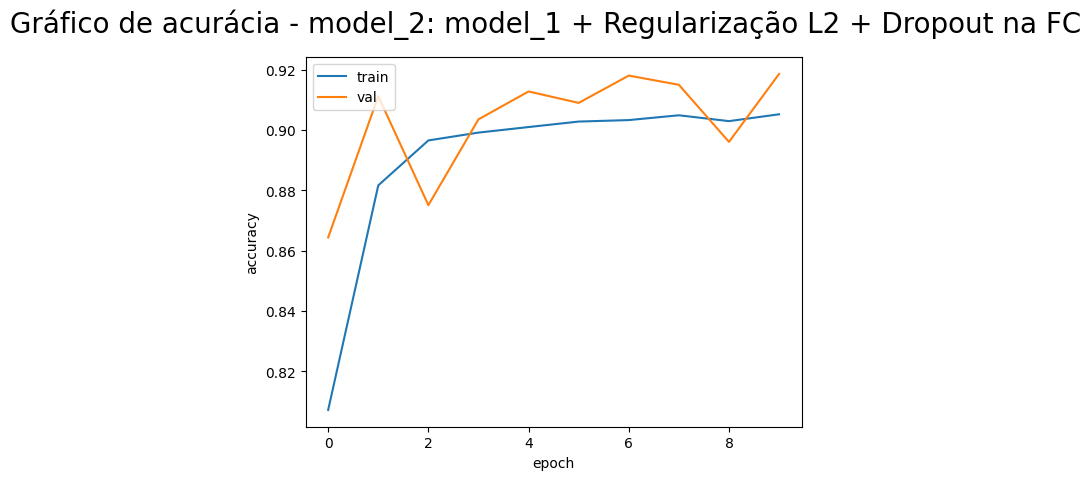

In [ ]:
plot_loss_accuracy_2(history_2, "model_2: model_1 + Regularização L2 + Dropout na FC")

339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


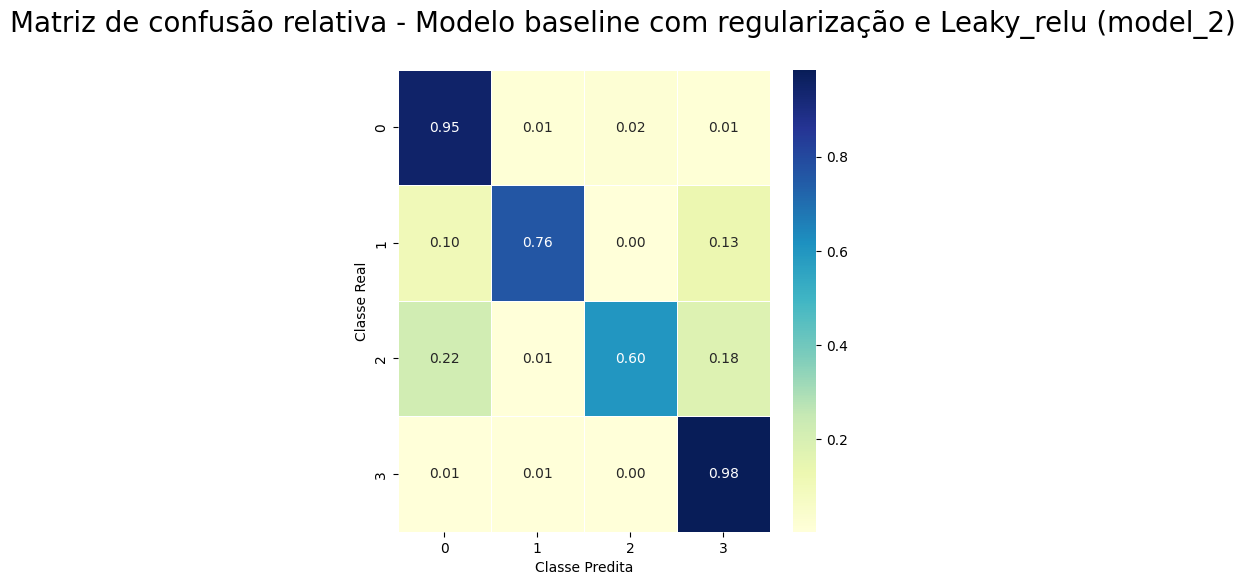

In [ ]:
# imprimir matriz de confusão relativa
plot_confusion_matrix(y_val, np.argmax(model_2.predict(X_val), axis=1), tag="Modelo baseline com regularização e Leaky_relu (model_2)")

In [ ]:
# calcular acurácia balanceada para model_2

# Fazer previsões no conjunto de validação
y_pred = model_2.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades para classes previstas

# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(y_val, y_pred_classes)

print(f"Acurácia Balanceada para model_2: {balanced_acc:.4f}")

339/339 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Acurácia Balanceada para model_2: 0.8241


In [ ]:
# # Salvar o modelo
# model_2.save('/content/drive/MyDrive/Deep Learning/model_2.keras')

# # Salvar histórico de treinamento
# with open('/content/drive/MyDrive/Deep Learning/historico_model_2.pkl', 'wb') as f:
#     pickle.dump(history_2.history, f)

In [ ]:
# # Carregar modelo treinado
# model_2 = tf.keras.models.load_model('/content/drive/MyDrive/Deep Learning/model_2.keras')

# # Carregar histórico de treinamento
# with open('/content/drive/MyDrive/Deep Learning/historico_model_2.pkl', 'rb') as f:
#     history_2 = pickle.load(f)

model_2 = tf.keras.models.load_model('model_2.keras')

### model_var_2

In [9]:
# vamos tentar uma variação do model_2, mas adicionando regularização L2 na ultima camada e
# reduzir o dropout para 0.4
# aplicar batch normalization
from tensorflow.keras.utils import to_categorical

# Converte rótulos para one-hot encoding
y_train_oh = to_categorical(y_train, num_classes=4)
y_val_oh = to_categorical(y_val, num_classes=4)
y_test_oh = to_categorical(y_test, num_classes=4)



In [ ]:
from tensorflow.keras import regularizers

# Variação 2 do baseline: mais camadas, inicializações, regularização e dropout um pouco menor.
model_var_2 = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', input_shape=(64, 64, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

model_var_2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history_var_2 = model_var_2.fit(
    X_train, y_train_oh,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val_oh)
)


c:\Users\czset\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 510s 661ms/step - accuracy: 0.7619 - loss: 1.1689 - val_accuracy: 0.9141 - val_loss: 0.5233
Epoch 2/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 510s 669ms/step - accuracy: 0.9102 - loss: 0.5206 - val_accuracy: 0.9206 - val_loss: 0.4824
Epoch 3/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 455s 597ms/step - accuracy: 0.9374 - loss: 0.4250 - val_accuracy: 0.9147 - val_loss: 0.4795
Epoch 4/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 493s 647ms/step - accuracy: 0.9467 - loss: 0.3836 - val_accuracy: 0.9410 - val_loss: 0.4016
Epoch 5/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 467s 613ms/step - accuracy: 0.9514 - loss: 0.3636 - val_accuracy: 0.9394 - val_loss: 0.4112
Epoch 6/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 465s 610ms/step - accuracy: 0.9541 - loss: 0.3400 - val_accuracy: 0.9457 - val_loss: 0.3806
Epoch 7/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 465s 610ms/step - accuracy: 0.9567 - loss: 0.3320 - val_accuracy: 0.9428 - val_loss: 0.3839
Epoch 8/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 458s 601ms/step - accuracy: 0.9592 -

TypeError: plot_loss_accuracy() takes 0 positional arguments but 1 was given

339/339 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step


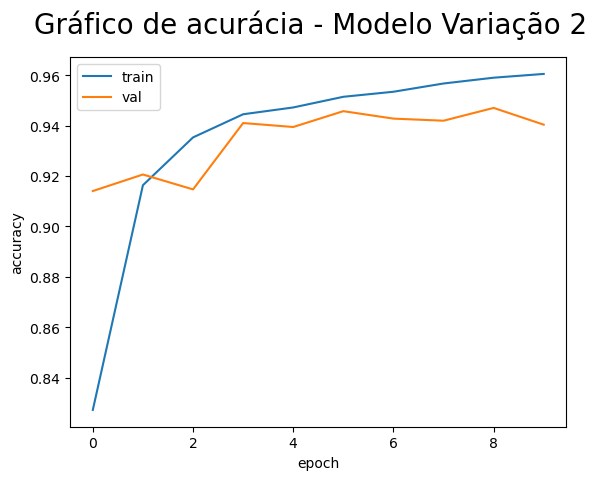

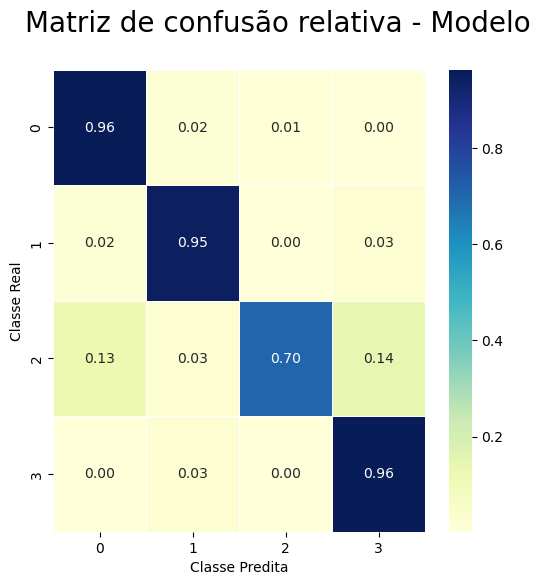

Acurácia Balanceada para model_var_2: 0.8935


In [ ]:
plot_loss_accuracy_2(history_var_2, "Modelo Variação 2")
pred_var_2 = model_var_2.predict(X_val)
plot_confusion_matrix(y_val, np.argmax(pred_var_2, axis=1))

# calcular acurácia balanceada
from sklearn.metrics import balanced_accuracy_score

# Fazer previsões no conjunto de validação
y_pred_classes = np.argmax(pred_var_2, axis=1)  # Converter probabilidades para classes previstas

# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(y_val_oh.argmax(axis=1), y_pred_classes)

print(f"Acurácia Balanceada para model_var_2: {balanced_acc:.4f}")

In [7]:
# import pickle
# # save model_var_2
# model_var_2.save('model_var_2.keras')
# # save history_var_2
# with open('history_var_2.pkl', 'wb') as f:
#     pickle.dump(history_var_2.history, f)

# load model_var_2
model_var_2 = tf.keras.models.load_model('model_var_2.keras')
# # load history_var_2
# with open('history_var_2.pkl', 'rb') as f:
#     history_var_2 = pickle.load(f)

### Discussão:

Abaixo seguem as análises de cada modelo. Obs: para treinamento, usou-se 10 épocas em todos os modelos.

- Base model

Arquitetura simples, com duas camadas convolucionais e duas densas. Não foi observado overfitting. Observa-se dificuldade em prever as classes 1 e 2, embora tenha previsto bem as classes 0 e 3. Ele "confundiu" a classe 2 com a classe 0. Isso penalizou um pouco a acurácia balanceada, que ficou em 0.81.

- model_1

Aqui, acrescentou-se mais duas camadas convolucionais e adicionado o ativador he_normal, buscando maior convergência do modelo. Vemos que a acurácia do treino e da validação aumenta juntamente das épocas de treinamento, porém, a partir da 5a época, a acurácia da validação supera a de treinamento, a qual começa ser penalizada. Isso é um fenômeno contra intuitivo, pois, normalmente, espera-se acurácia maior no conjunto de treinamento. Mesmo assim, na matriz de confusão, observa-se que a classe 0 parou de ser confundida com a classe 2, e a predição foi correta, de forma geral, resultando em uma acurácia balanceada de 0.88.

- model_2

O model_2 não trouxe adição de novas camadas convolucionais. Acrescentou-se regularização L2 em todas as camadas e dropout=0.5 antes da última camada densa. O objetivo era tornar a curva de acurácia mais suave e evitar overfitting.
Embora a curva de acurácia tenha apresentado menos ruído, essa seguiu com um comportamento estranho, em que a acurácia do conjunto de validação superou a do conjunto de treinamento. O modelo voltou a confundir as classes 0 e 2, o que penalizou a acurácia balanceada, que ficou em 0.82.

- model_var_2

Para o model_var_2, buscou-se melhorar os hiperparâmetros do model_2. A regularização L2 foi aplicada somente na penúltima camada densa, reduziu-se o dropout de 0.5 para 0.4 e aplicou-se batch normalization entre todas as camadas.
A curva de acurácia apresentou melhoria em termos do comportamento estranho citado anteriormente - o conjunto de validação ficou com acurácia inferior à acurácia do conjunto de treinamento. Não foi observado overfitting para 10 épocas (talvez, seja necessário aumentar o número de épocas para verificar ocorrência de overfitting). Na matriz de confusão, observa-se que a predição das classes teve bom desempenho, embora o modelo ainda tenha confundido um pouco a classe 2 com a 0, mas em menor intensidade que nos modelos anteriores. Isso resultou em uma acurácia balanceada de 0.89.



### Treinamento com Arquitetura Pré-Treinada (ImageNet)

3. (1.5) Escolha uma arquitetura de rede neural que tenha sido pré-treinada na ImageNet e seja adequada para extração de características. Descarte a camada de saída original e congele todas as demais camadas da arquitetura. Em seguida, adicione uma nova camada de saída que corresponda ao número de classes específicas do problema. Prossiga com o treinamento apenas dessa nova camada.
Após concluir o treinamento, compare o desempenho dessa arquitetura com o melhor modelo que você desenvolveu anteriormente.

Note que as redes treinadas na ImageNet esperam uma entrada com 3 canais (imagems coloridas), e o conjunto de dados do problema possui apenas um canal. Uma solução simples é a repetição da imagem cinza nos 3 canais.

### Modelo pré treinado VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Corrigir input_shape para compatibilidade com VGG16
input_shape = (64,64,3)

# Carregar VGG16 pré-treinado no ImageNet, sem a camada de classificação original
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar TODAS as camadas da base
for layer in base_model.layers:
    layer.trainable = False

# Criar modelo adicionando novas camadas
frozen_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(4, activation='softmax')  # 4 classes do OCTMNIST
])

# Exibir a estrutura do modelo
frozen_model.summary()


# compilar o modelo
sgd = tf.keras.optimizers.SGD (learning_rate = 0.005, momentum = 0.9, decay = 0.001)

# Regularização "early stopping", usando o conjunto de validação.
#
early = tf.keras.callbacks.EarlyStopping (monitor = 'val_loss', patience = 5, restore_best_weights = True)

frozen_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

print('[done]')


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

[done]


C:\Users\czset\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


#### preprocessamento para VGG16

In [ ]:
# Para usar VGG16, precisamos alterar o formato das imagens de input para (None, 64, 64, 3)
def preprocess_image(img, label):
    img = tf.image.grayscale_to_rgb(img)  # Converter para 3 canais
    img = tf.image.resize(img, [64, 64])  # Redimensionar para 64x64
    img = tf.ensure_shape(img, [64, 64, 3])  # Garantir que a saída tenha formato fixo
    return img, label
# Aplicar a função ao pipeline do dataset
# Criar dataset incluindo imagens e rótulos
X_train_rgb = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .map(preprocess_image) \
    .batch(32) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

X_val_rgb = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .map(preprocess_image) \
    .batch(32) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

# verificar formato
print(X_train_rgb)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>


#### Compilar modelo

In [ ]:
# Ajustar learning rate para acelerar convergência
learning_rate = 0.002  # Teste valores como 0.002 ou 0.005
adam = Adam(learning_rate=learning_rate)

# Regularização "early stopping", usando o conjunto de validação
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar modelo com ajustes no otimizador
frozen_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

print('[done]')

[done]


#### Treinar modelo

In [ ]:
# # Treinar modelo
# history_3 = frozen_model.fit(X_train_rgb, epochs=10, callbacks=[early], validation_data=X_val_rgb)

# Treinar modelo
history_3 = frozen_model.fit(
    X_train_rgb,
    epochs=10,
    steps_per_epoch=200,  # Reduz número de batches por época
    validation_data=X_val_rgb,
    validation_steps=50,  # Reduz número de batches na validação
    callbacks=[early]
)


Epoch 1/10


200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 261ms/step - accuracy: 0.5919 - loss: 7.0512 - val_accuracy: 0.7750 - val_loss: 1.8424
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - accuracy: 0.7355 - loss: 1.9474 - val_accuracy: 0.7694 - val_loss: 1.4804
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 247ms/step - accuracy: 0.7758 - loss: 1.5306 - val_accuracy: 0.7962 - val_loss: 1.2785
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.7901 - loss: 1.2473 - val_accuracy: 0.8219 - val_loss: 1.2971
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 231ms/step - accuracy: 0.7811 - loss: 1.3076 - val_accuracy: 0.7919 - val_loss: 0.9928
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - accuracy: 0.7844 - loss: 1.1799 - val_accuracy: 0.7994 - val_loss: 1.1880
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 214ms/step - accuracy: 0.7601 - loss: 1.2599 - val_accuracy: 0.8250 - val_loss: 1.2276
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - accuracy: 0.7895 - loss: 1.1617 - val

In [ ]:
# Salvar o modelo
import pickle

frozen_model.save('model_VGG.keras')

# Salvar histórico de treinamento
with open('historico_model_VGG16.pkl', 'wb') as f:
    pickle.dump(history_3.history, f)

In [ ]:
## Carregar modelo treinado
# frozen_model = tf.keras.models.load_model('model_VGG.keras')

# # Carregar histórico de treinamento
# with open('historico_model_VGG16.pkl', 'rb') as f:
#     history_3 = pickle.load(f)

339/339 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step


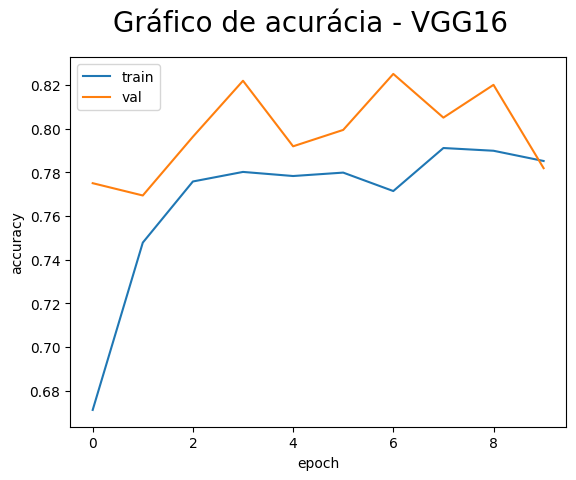

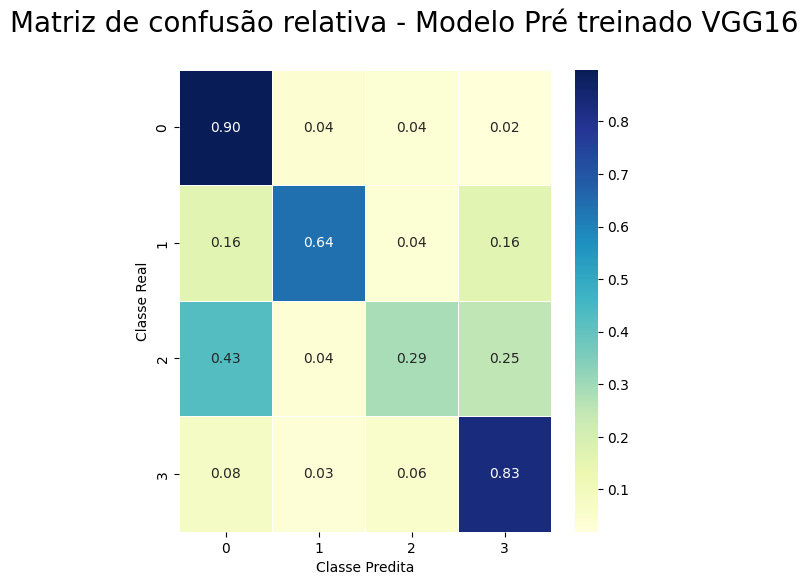

In [ ]:
# Imprimir gráfico para verificar acurácia e overfitting
plot_loss_accuracy_2(history_3, "VGG16")

# imprimir matriz de confusão relativa
plot_confusion_matrix(y_val, np.argmax(frozen_model.predict(X_val_rgb), axis=1), tag="Modelo Pré treinado VGG16")

In [ ]:
# calcular acurácia balanceada para frozen_model

# Fazer previsões no conjunto de validação
y_pred = frozen_model.predict(X_val_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades para classes previstas

# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(y_val, y_pred_classes)

print(f"Acurácia Balanceada: {balanced_acc:.4f}")


339/339 ━━━━━━━━━━━━━━━━━━━━ 64s 189ms/step
Acurácia Balanceada: 0.2588


### Discussão:

A rede pré-treinada VGG16 foi escolhida para este experimento. Observou-se que a curva de acurácia apresentou sinais de overfitting, mas houve o retorno do comportamento de acurácia de validação superior a acurácia de treinamento. De qualquer forma, a matriz de confusão mostra um modelo fraco para predizer as classes corretas. A acurácia balanceada foi de 0.26, bem inferior quando comparada ao model_var_2, com 0.89 de acurácia balanceada.

É provável que o VGG16 as-is (isto é, mantendo todas as camadas de aprendizado congeladas, exceto a camada final de classificação) não consiga aprender os padrões no dataset providenciado. Portanto, ajustes finos se fazem necessários para melhorar a classificação.

### VGG16 com Ajuste Fino das Camadas de Extração de Características

4. (1.5) Descongele as camadas da rede responsáveis pela extração de características e realize o ajuste fino (fine-tuning) dessa parte do modelo. Em seguida, compare os novos resultados com os obtidos anteriormente, analisando detalhadamente as diferenças e identificando possíveis melhorias no desempenho.

In [ ]:
# Descongelar as últimas camadas para fine-tuning
for layer in base_model.layers[-4:]:  # Últimas 4 camadas treináveis
    layer.trainable = True


# Criar modelo adicionando novas camadas
fine_tuned_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(4, activation='softmax')  # 4 classes do OCTMNIST
])

# Exibir a estrutura do modelo
fine_tuned_model.summary()


# Compilar o modelo
learning_rate = 0.0001  # Taxa de aprendizado menor para ajuste fino
adam = Adam(learning_rate=learning_rate)

# Regularização "early stopping", usando o conjunto de validação
early = tf.keras.callbacks.EarlyStopping (monitor = 'val_loss', patience = 5, restore_best_weights = True)

fine_tuned_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print('[done]')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 7,081,476 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

[done]


In [ ]:
# Treinar modelo
history_fine_tuned = fine_tuned_model.fit(
    X_train_rgb,
    epochs=10,  # Menos épocas para evitar overfitting
    steps_per_epoch=200,
    validation_data=X_val_rgb,
    validation_steps=50,
    callbacks=[early]
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 303ms/step - accuracy: 0.7149 - loss: 1.9250 - val_accuracy: 0.8694 - val_loss: 0.4443
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 302ms/step - accuracy: 0.8337 - loss: 0.4775 - val_accuracy: 0.8769 - val_loss: 0.3811
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 302ms/step - accuracy: 0.8685 - loss: 0.3748 - val_accuracy: 0.8813 - val_loss: 0.3750
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - accuracy: 0.8800 - loss: 0.3523 - val_accuracy: 0.8781 - val_loss: 0.3665
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 58s 290ms/step - accuracy: 0.8882 - loss: 0.3447 - val_accuracy: 0.8981 - val_loss: 0.3303
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.8898 - loss: 0.3200 - val_accuracy: 0.8900 - val_loss: 0.3566
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.8836 - loss: 0.3384 - val_accuracy: 0.9075 - val_loss: 0.3180
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 318ms/step - accuracy: 0.8979 - loss: 0

In [ ]:
# Salvar o modelo
fine_tuned_model.save('model_VGG_ft.keras')

# Salvar histórico de treinamento
with open('historico_model_VGG16_ft.pkl', 'wb') as f:
    pickle.dump(history_fine_tuned.history, f)

# # Carregar modelo treinado
# fine_tuned_model = tf.keras.models.load_model('model_VGG_ft.keras')

# # Carregar histórico de treinamento
# with open('historico_model_VGG16_ft.pkl', 'rb') as f:
#     history_fine_tuned = pickle.load(f)

339/339 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step


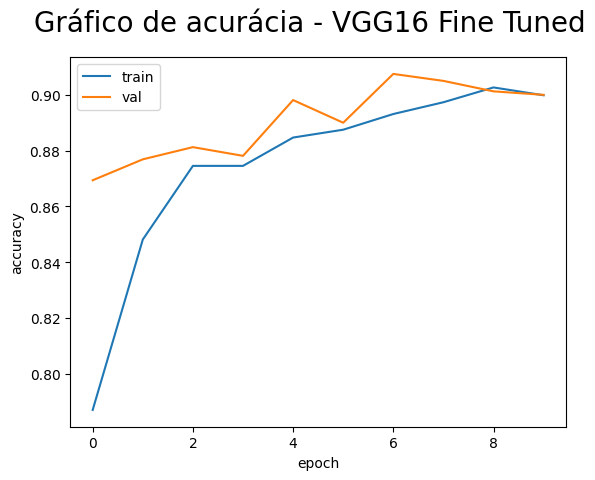

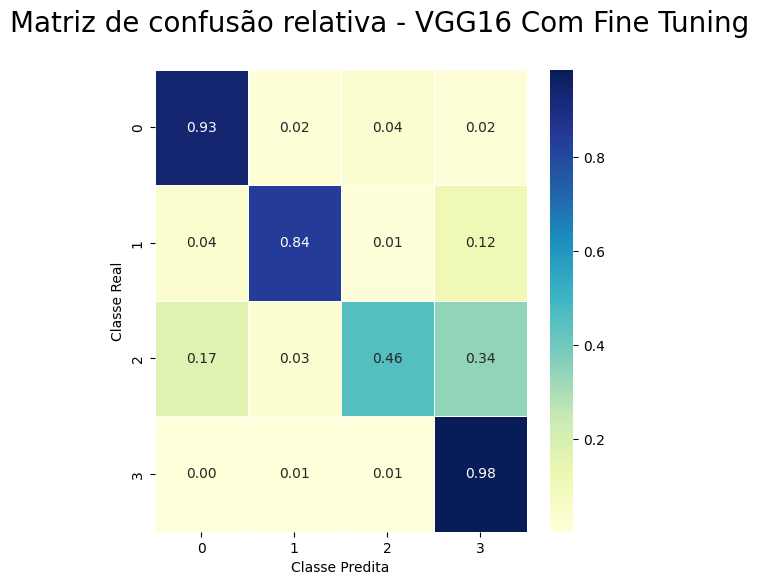

In [ ]:
# Imprimir gráfico para verificar acurácia e overfitting
plot_loss_accuracy_2(history_fine_tuned, "VGG16 Fine Tuned")

# imprimir matriz de confusão relativa
plot_confusion_matrix(y_val, np.argmax(fine_tuned_model.predict(X_val_rgb), axis=1), tag="VGG16 Com Fine Tuning")

In [ ]:
# calcular acurácia balanceada para fine_tuned_model

# Fazer previsões no conjunto de validação
y_pred = fine_tuned_model.predict(X_val_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades para classes previstas

# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(y_val, y_pred_classes)

print(f"Acurácia Balanceada: {balanced_acc:.4f}")

339/339 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step
Acurácia Balanceada: 0.8024


### Discussão:

Congelar todas as camadas de um modelo pré-treinado (VGG16) e treinar apenas a nova camada de saída, o desempenho inicial ficou muito abaixo do esperado (acurácia balanceada em torno de 0,26, próximo do aleatório). Realizou-se então o fine-tuning descongelando as últimas camadas convolucionais do VGG16 e continuando o treinamento nessas camadas. Esse ajuste fino resultou em grande melhoria de desempenho: a acurácia balanceada saltou para aproximadamente 0,80, indicando que o modelo passou a extrair características mais relevantes do conjunto OCTMNIST. A matriz de confusão do modelo fine-tuned mostrou distribuição de acertos bem mais equilibrada entre as classes em comparação à versão congelada, que praticamente falhou em distinguir os padrões das doenças. Comparando com modelos anteriores (treinados do zero, como o modelo_var_2 com 0,89 de acurácia balanceada), o modelo VGG16 fine-tunado ainda não os superou. Ou seja, apesar do ganho significativo em relação à versão pré-treinada sem ajustes, seu desempenho permaneceu ligeiramente inferior ao melhor modelo customizado. Isso sugere que, dadas as características específicas das imagens médicas OCT, o modelo pré-treinado não atingiu todo seu potencial com o fine-tuning limitado realizado.
Pode ser que seja necessario descongelar um número maior de camadas para um tunning mais refinado.

Um ponto de desafio foi o pré-processamento necessário dos dados de treinamento (X_train) para que a VGG16 rodasse. No Google Colab, não foi possível realizar essa operação pois este crasheava devido a excesso de uso de memória RAM. A utilização de processamento local resolveu o problema.

### Seleção do Modelo com Melhor Acurácia Balanceada
5. (2.0) Selecione o modelo com a melhor acurácia balanceada e avalie-o utilizando o conjunto de teste. De forma clara e objetiva, destaque os principais desafios enfrentados durante o treinamento, explicando as estratégias adotadas para superá-los. Reflita também sobre a escolha dos hiperparâmetros, discutindo como essas decisões podem ter impactado o desempenho final do modelo.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Acurácia Balanceada para model_var_2 no CONJUNTO DE TESTE: 0.7670


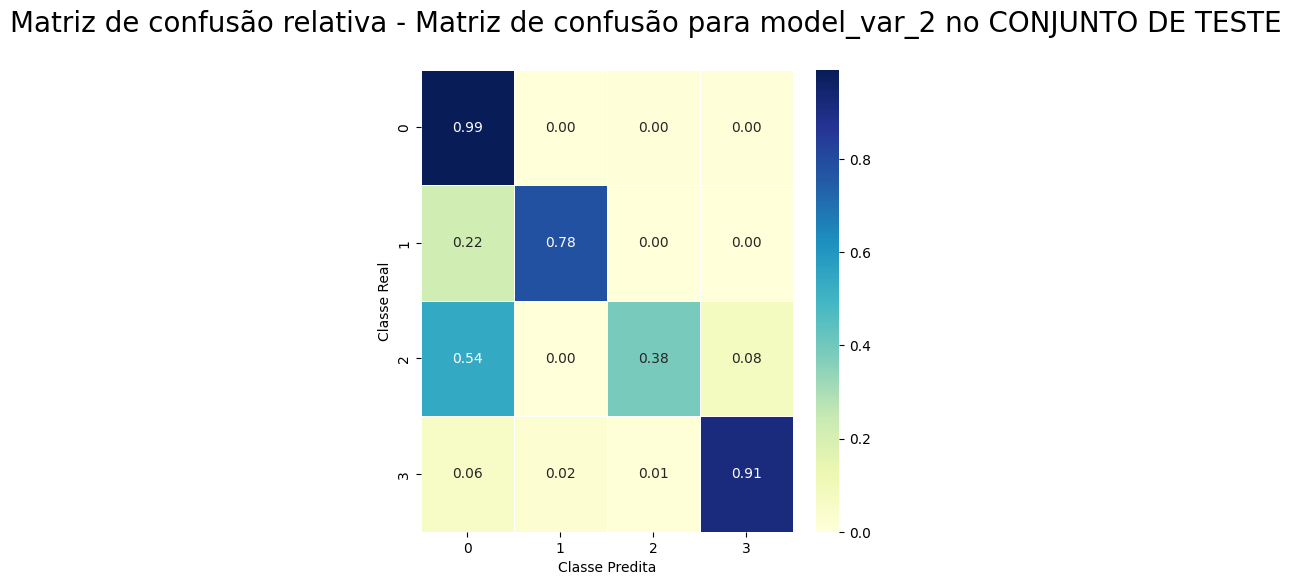

In [10]:
# melhor modelo de acuracia balanceada: model_var_2

# Fazer previsões no conjunto de teste
y_pred = model_var_2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades para classes previstas
# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(y_test_oh.argmax(axis=1), y_pred_classes)
print(f"Acurácia Balanceada para model_var_2 no CONJUNTO DE TESTE: {balanced_acc:.4f}")

# imprimir matriz de confusão relativa
plot_confusion_matrix(y_test, np.argmax(y_pred, axis=1), tag="Matriz de confusão para model_var_2 no CONJUNTO DE TESTE")

Discussão:

O modelo com melhor desempenho na validação foi o model_var_2, e ele foi utilizado na avaliação final com o conjunto de teste. A acurácia balanceada obtida foi de aproximadamente 0,77, mostrando que o modelo generalizou bem para dados não vistos, mesmo com uma leve queda em relação à validação. Durante o treinamento, um dos principais desafios foi lidar com overfitting. Isso foi resolvido com o uso combinado de Dropout, regularização L2 e BatchNormalization. Outro ponto observado foi que, em alguns modelos, a acurácia de validação superava a de treino, comportamento incomum que foi corrigido ao estabilizar os hiperparâmetros e revisar o uso de dropout. No caso da transferência de aprendizado, o desempenho inicial foi muito baixo, mas o fine-tuning melhorou bastante os resultados. Ainda assim, não superou o modelo customizado, o que mostra que nem sempre o uso de redes pré-treinadas é superior, principalmente quando o domínio das imagens é muito específico. As escolhas de ativação (ReLU), inicialização (He Normal), e regularização foram fundamentais para o bom desempenho final.



### Aplicação do Grad-CAM para Visualização de Classes

6. (2.0) Utilizando o modelo com a melhor acurácia balanceada, aplique a técnica de visualização Grad-CAM para cada classe do conjunto de dados. Para cada classe, escolha duas imagens: uma corretamente classificada e outra incorretamente classificada pelo modelo. Use o Grad-CAM para identificar as áreas das imagens que mais influenciaram as previsões do modelo. Descreva suas observações sobre as regiões destacadas e discuta suas conclusões a partir dessa análise.

#### O algoritmo Grad-CAM

In [ ]:
from tensorflow import keras
import matplotlib as mpl

def get_img_array(img_path, size):
  '''
  Carrega uma imagem a partir de um endereço, transforma em um array e em um batch.
  Espera uma imagem colorida (3 canais).
  '''
  # `img` é uma imagem PIL de tamanho 299x299
  img = keras.utils.load_img(img_path, target_size=size)
  # `array` é um array Numpy float32 com forma (299, 299, 3)
  array = keras.utils.img_to_array(img)
  # Adicionamos uma dimensão para transformar nosso array em um "batch"
  # de tamanho (1, 299, 299, 3)
  array = np.expand_dims(array, axis=0)

  return array

def unwrap_model(model, last_conv_layer_name, base_model_name):
  '''
  Essa função extrai os outputs de um modelo aninhado dentro do modelo principal.
  Por exemplo: caso o modelo utilize uma resnet como extrator de características,
  se a ultima camada convolucional for do modelo da resnet, 'last_conv_layer_name'
  apenas será visível a partir do modelo aninhado.
  '''
  n_model = model.get_layer(base_model_name)
  n_model_conv_out = n_model.get_layer(last_conv_layer_name).output
  inp = n_model.input

  # Executa o resto da rede, supondo que o modelo base era a primeira camada
  other_layers = model.layers[1:]
  curr_out = n_model_conv_out
  for layer in other_layers:
    curr_out = layer(curr_out)

  return tf.keras.models.Model(inp, [n_model_conv_out, curr_out])

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, base_model_name=None):
  # Primeiro, criamos um modelo que mapeia a imagem de entrada para as ativações
  # da última camada convolucional, bem como as previsões de saída
  # Caso o modelo utilize um outro modelo pré treinado (fine-tunning), e sua ultima
  # camada convolucional esteja dentro deste modelo, usamos o parâmetro base_model_name
  # para criarmos o modelo do GradCAM.
  if  base_model_name is None:
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.layers[-1].output]
    )
  else:
    grad_model = unwrap_model(model, last_conv_layer_name, base_model_name)

  # Em seguida, computamos o gradiente da classe prevista no topo para nossa imagem de entrada
  # em relação às ativações da última camada convolucional
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # Este é o gradiente do neurônio de saída (mais previsto ou escolhido)
  # em relação ao mapa de características de saída da última camada convolucional
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # Este é um vetor onde cada entrada é a intensidade média do gradiente
  # sobre um canal específico do mapa de características
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # Multiplicamos cada canal no array do mapa de características
  # por "quão importante esse canal é" em relação à classe prevista no topo
  # e então somamos todos os canais para obter o mapa de calor de ativação da classe
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # Para fins de visualização, também normalizamos o mapa de calor entre 0 e 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

def show_heatmap_with_image(img, heatmap, alpha=0.5):
  '''
  Mostra uma imagem junto de seu mapa de calor (heatmap).
  O parâmetro alpha controla a opacidade do mapa de calor.
  '''
  # Redimensionar o mapa de calor para um intervalo de 0 a 255
  heatmap = np.uint8(255 * heatmap)

  # Usar o mapa de cores 'jet' para colorir o mapa de calor
  jet = mpl.colormaps["jet"]

  # Usar os valores RGB do mapa de cores
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Criar uma imagem com o mapa de calor colorizado em RGB
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  # Sobrepor o mapa de calor na imagem original
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)

  plt.figure(figsize=(12, 6))
  plt.imshow(superimposed_img, cmap="jet")
  plt.title("Grad-CAM Heatmap")
  plt.grid(False)
  plt.axis('off')
  plt.colorbar()
  plt.show()

#### Exemplo de Visualização de Ativações de Classe com Grad-CAM

##### Parâmetros configuráveis
Esses parâmetros devem ser alterados para o seu modelo.

Para obter os valores de last_conv_layer_name, utilize o comando model.summary(), que exibirá os nomes de todas as camadas do modelo.

3592025/3592025 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


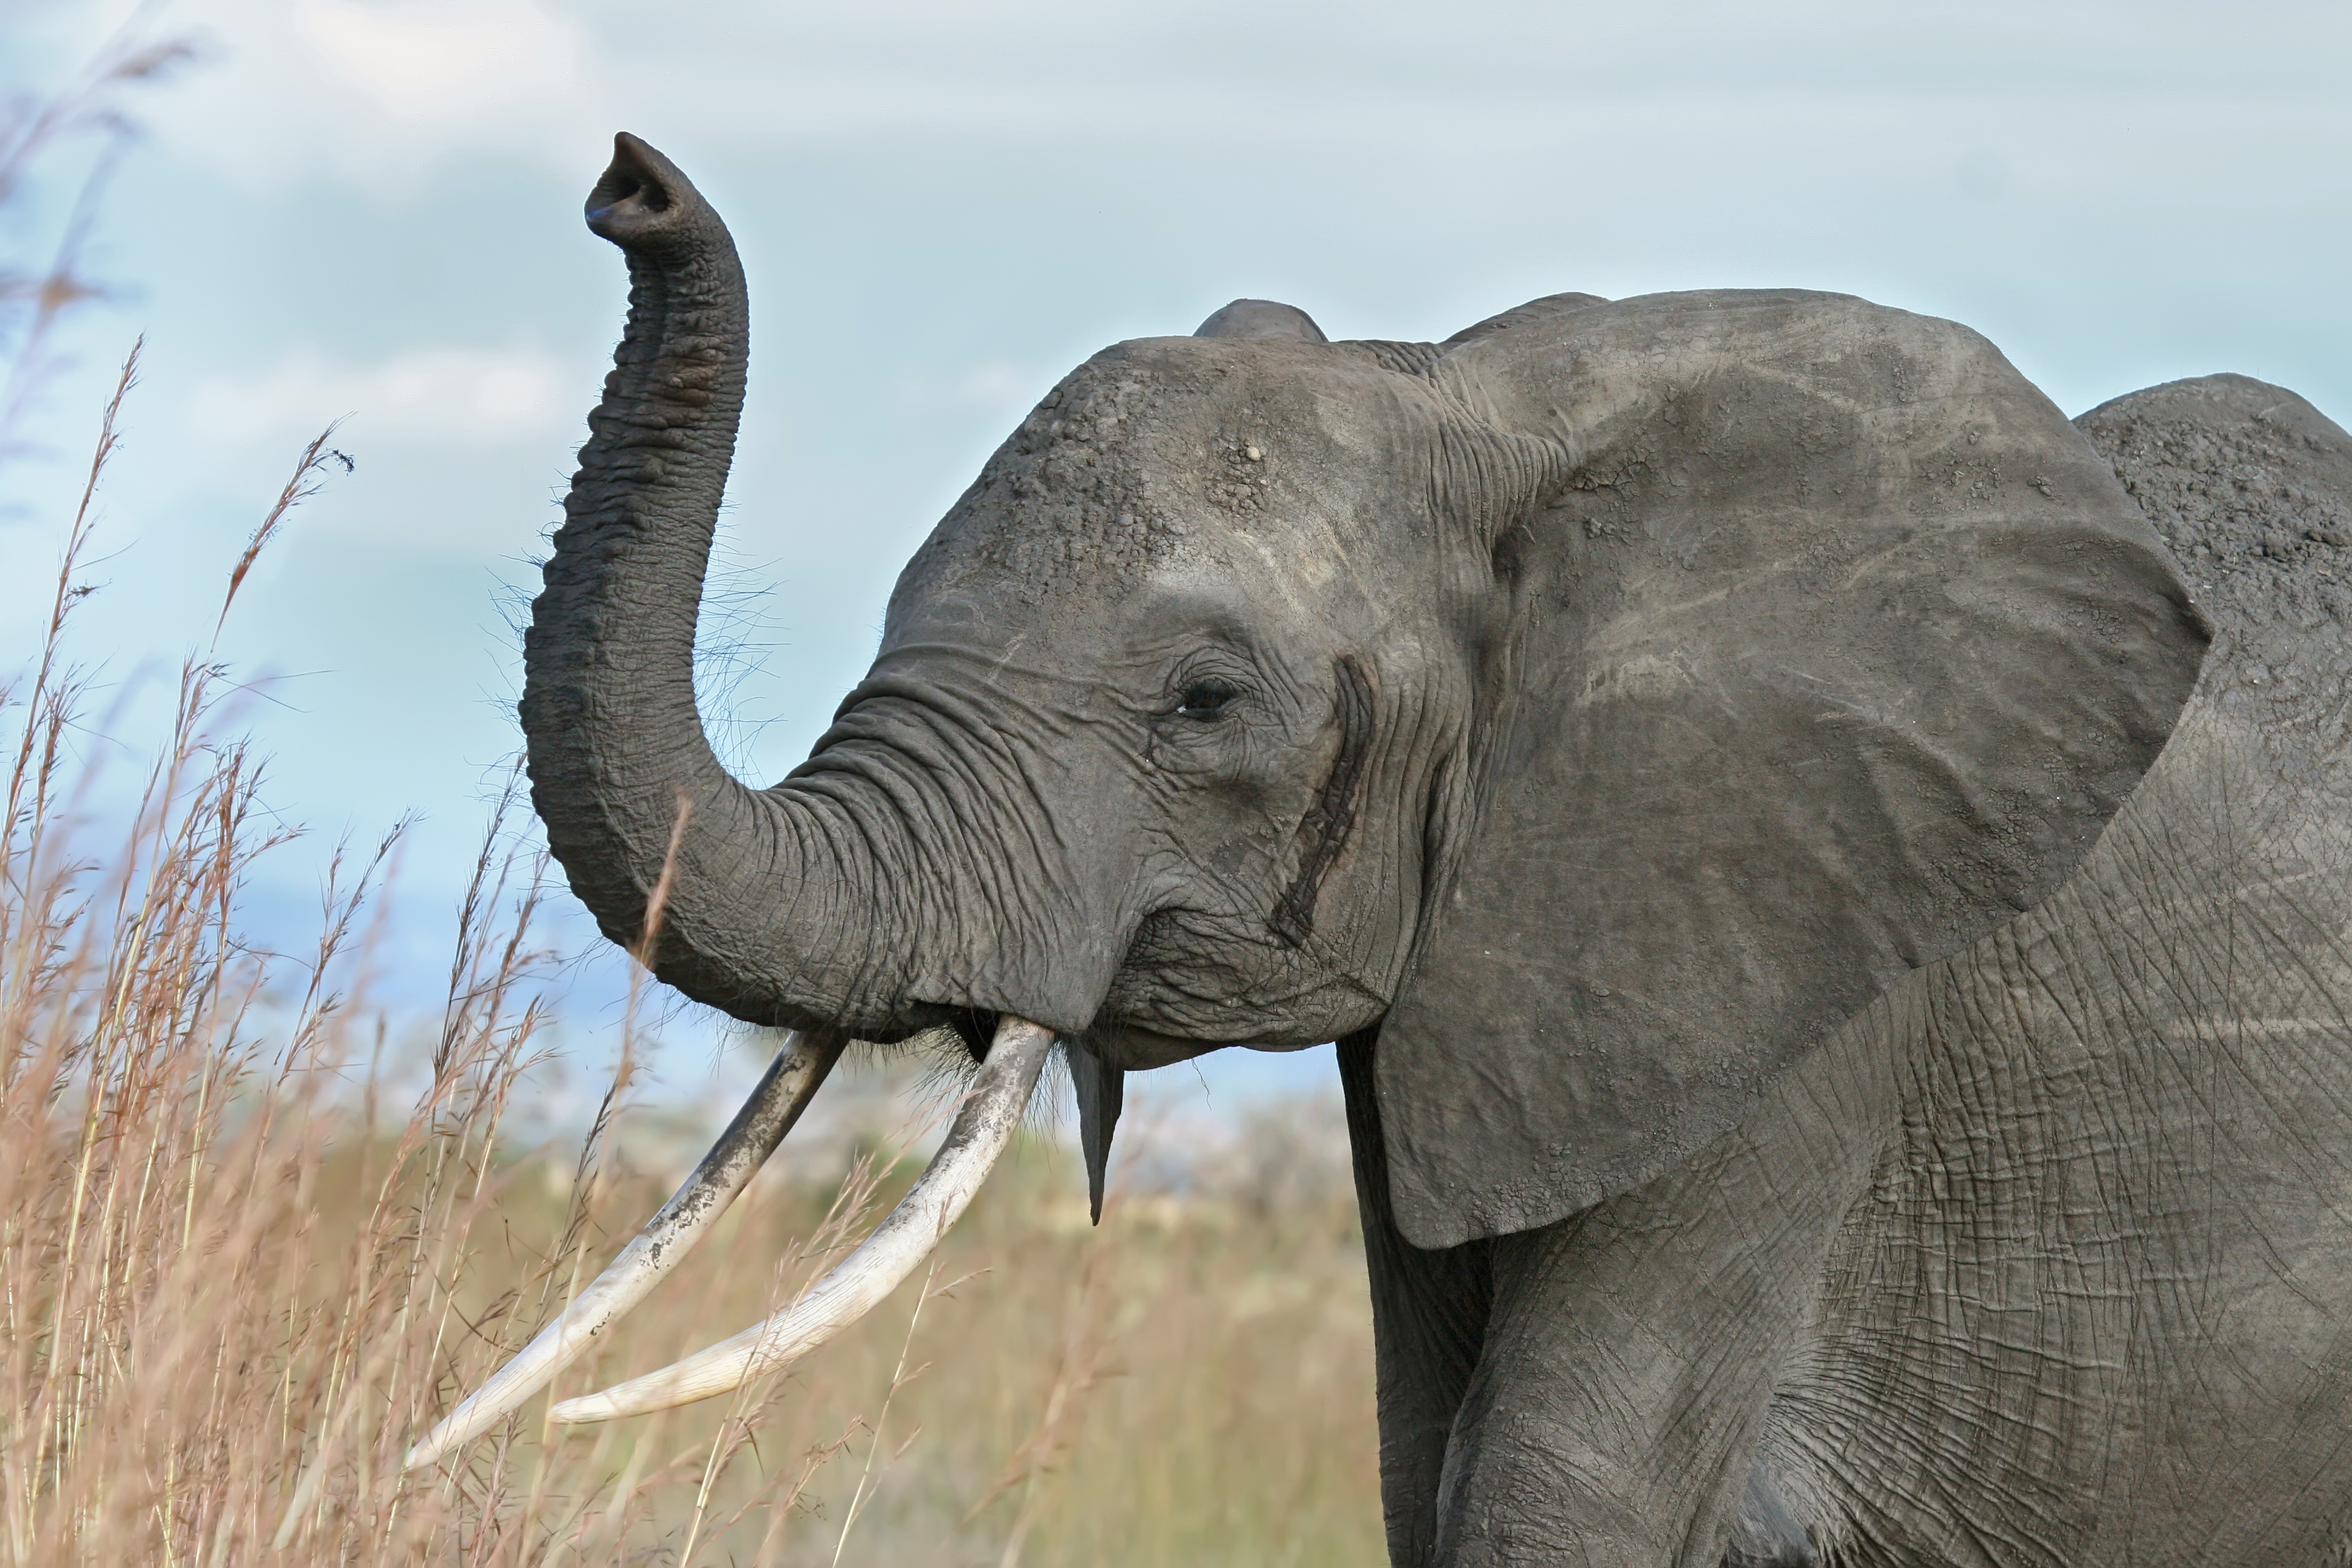

In [ ]:
from IPython.display import Image, display

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

img_path = keras.utils.get_file(
    "african_elephant.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/6/63/African_elephant_warning_raised_trunk.jpg"
)

display(Image(img_path))


##### Executando o algoritmo gradcam e visualizando o resultado

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Previsto: [('n02504458', 'African_elephant', 0.44424018)]


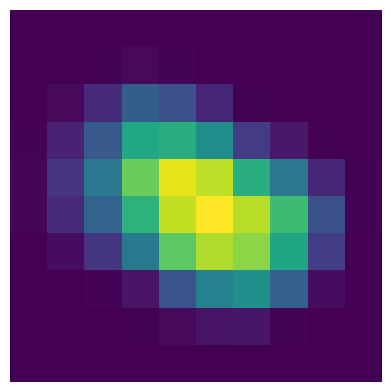

In [ ]:
# Preparar a imagem
img_array = preprocess_input(get_img_array(img_path, size=img_size))
# img_array = tf.convert_to_tensor(preprocess_input(get_img_array(img_path, size=img_size)))

# Construir o modelo
Xception_model = model_builder(weights="imagenet")

# Remover a função softmax da última camada
# Xception_model.layers[-1].activation = None

# Imprimir qual é a classe prevista no topo
preds = Xception_model.predict(img_array)
print("Previsto:", decode_predictions(preds, top=1)[0])

# Converte para tensor para evitar warnings do Keras
# img_array = tf.convert_to_tensor([img_array])

# Gerar o mapa de calor de ativação da classe
heatmap = make_gradcam_heatmap([img_array], Xception_model, last_conv_layer_name)

# Exibir o mapa de calor
plt.matshow(heatmap)
plt.grid(False)
plt.axis('off')
plt.show()


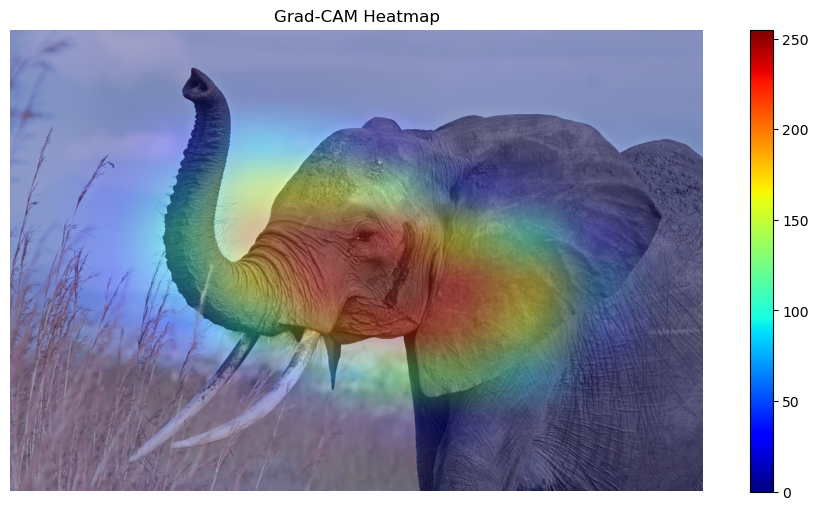

In [ ]:
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

show_heatmap_with_image(img, heatmap)

#### Agora é sua vez ...

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Primeiras previsões: [3 0 3 3 0 2 1 0 0 3]
Primeiros rótulos verdadeiros: [3 2 3 3 0 2 1 0 0 3]
Total de imagens corretamente classificadas: 767
Total de imagens incorretamente classificadas: 233
Classe 0:
  Correta: Encontrada
  Incorreta: Encontrada
Classe 1:
  Correta: Encontrada
  Incorreta: Encontrada
Classe 2:
  Correta: Encontrada
  Incorreta: Encontrada
Classe 3:
  Correta: Encontrada
  Incorreta: Encontrada
Última camada convolucional: conv2d_6
Aplicando Grad-CAM na imagem correta da classe 0


c:\Users\czset\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_244']
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


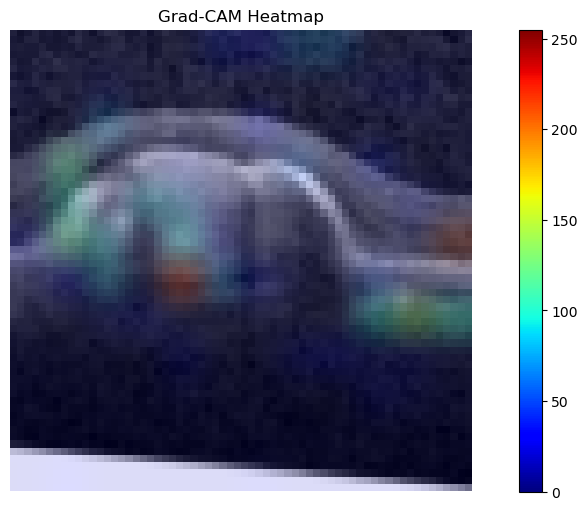

True Label: 0, Predicted Label: 0
Aplicando Grad-CAM na imagem incorreta da classe 0


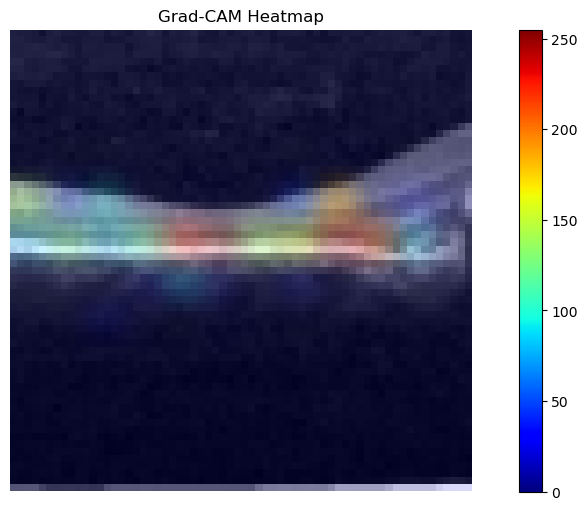

True Label: 0, Predicted Label: 3
Aplicando Grad-CAM na imagem correta da classe 1


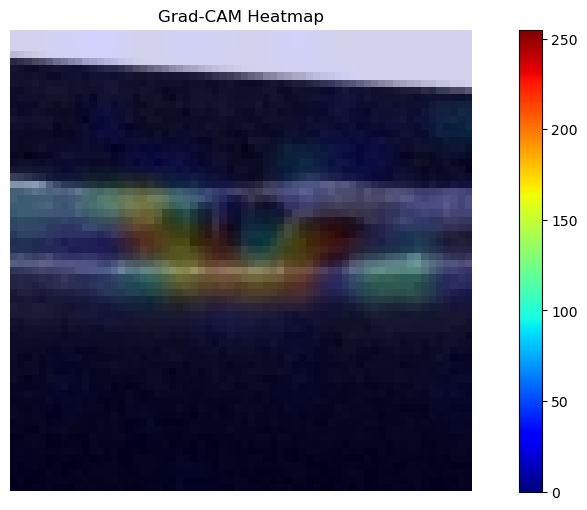

True Label: 1, Predicted Label: 1
Aplicando Grad-CAM na imagem incorreta da classe 1


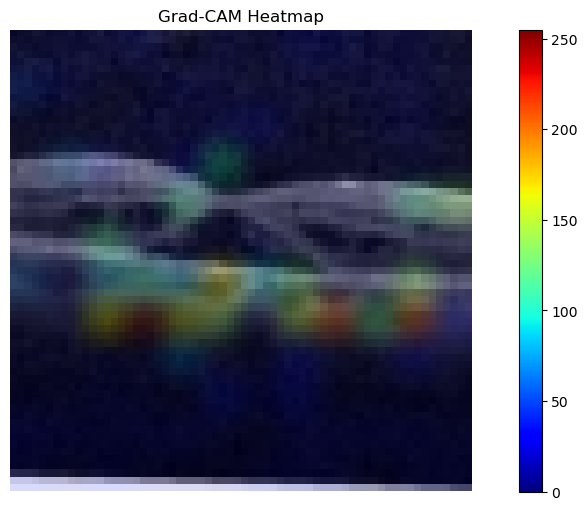

True Label: 1, Predicted Label: 0
Aplicando Grad-CAM na imagem correta da classe 2


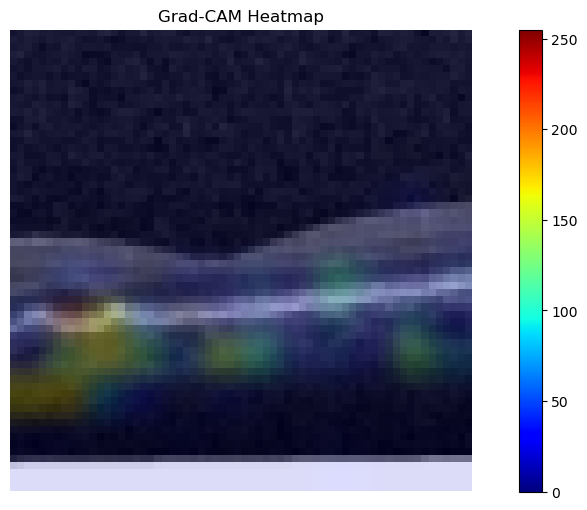

True Label: 2, Predicted Label: 2
Aplicando Grad-CAM na imagem incorreta da classe 2


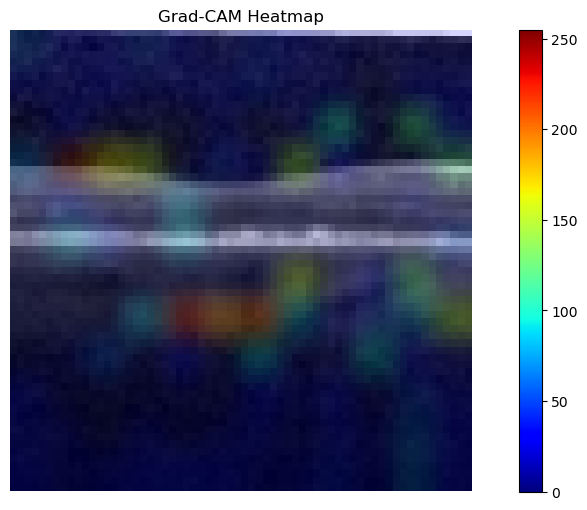

True Label: 2, Predicted Label: 0
Aplicando Grad-CAM na imagem correta da classe 3


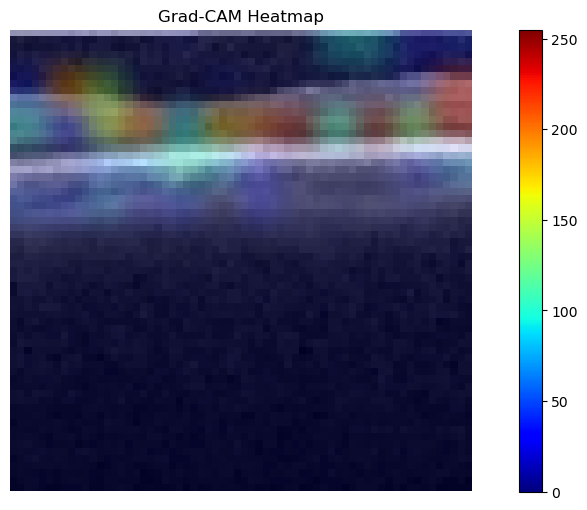

True Label: 3, Predicted Label: 3
Aplicando Grad-CAM na imagem incorreta da classe 3


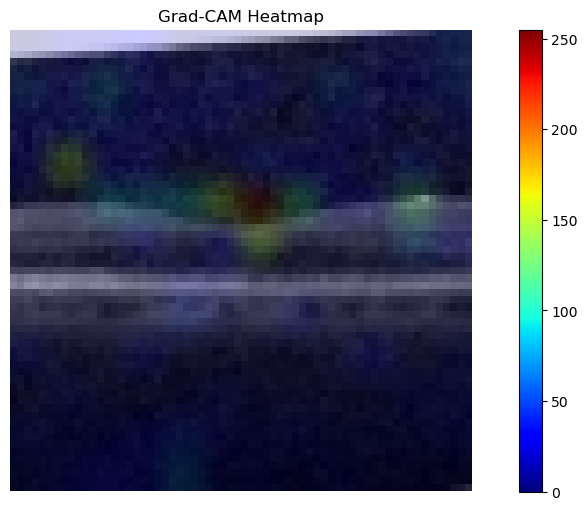

True Label: 3, Predicted Label: 0


In [ ]:
## Debugging

# Inicializa listas
correctly_classified = []
incorrectly_classified = []

# Obtém previsões do modelo
pred_test = model_var_2.predict(X_test)
pred_labels = np.argmax(pred_test, axis=1)
true_labels = np.argmax(y_test_oh, axis=1)

# Debug: Verifica primeiras previsões
print("Primeiras previsões:", pred_labels[:10])
print("Primeiros rótulos verdadeiros:", true_labels[:10])

# Identifica imagens corretamente e incorretamente classificadas
for i in range(len(X_test)):
    if pred_labels[i] == true_labels[i]:
        correctly_classified.append((X_test[i], true_labels[i], pred_labels[i]))
    else:
        incorrectly_classified.append((X_test[i], true_labels[i], pred_labels[i]))

# Debug: Verifica contagem de classificações
print("Total de imagens corretamente classificadas:", len(correctly_classified))
print("Total de imagens incorretamente classificadas:", len(incorrectly_classified))

selected_images = {}

# Seleciona uma imagem correta e uma incorreta para cada classe
for class_id in range(4):
    correct = next((img for img in correctly_classified if img[1] == class_id), None)
    incorrect = next((img for img in incorrectly_classified if img[1] == class_id), None)
    selected_images[class_id] = {"correct": correct, "incorrect": incorrect}
    print(f"Classe {class_id}:")
    print(f"  Correta: {'Encontrada' if correct else 'Não encontrada'}")
    print(f"  Incorreta: {'Encontrada' if incorrect else 'Não encontrada'}")

# Obtém última camada convolucional
last_conv_layer_name = None
for layer in reversed(model_var_2.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

# Debug: Confirma última camada convolucional
print("Última camada convolucional:", last_conv_layer_name)

# Aplica Grad-CAM para cada classe
for class_id, images in selected_images.items():
    if images["correct"] is not None:
        print(f"Aplicando Grad-CAM na imagem correta da classe {class_id}")
        apply_gradcam_with_functions(model_var_2, images["correct"][0], images["correct"][1], images["correct"][2], last_conv_layer_name)
    if images["incorrect"] is not None:
        print(f"Aplicando Grad-CAM na imagem incorreta da classe {class_id}")
        apply_gradcam_with_functions(model_var_2, images["incorrect"][0], images["incorrect"][1], images["incorrect"][2], last_conv_layer_name)


Discussão:

A técnica Grad-CAM foi aplicada para interpretar visualmente como o modelo final tomava suas decisões. Para cada classe (CNV, DME, Drusen e Normal), foram escolhidas duas imagens: uma corretamente classificada e uma incorretamente classificada. Para as imagens corretamente classificadas, o modelo focou exatamente nas regiões esperadas — como as áreas subretinianas no caso da CNV e a mácula inchada nas imagens de DME. Para Drusen, os hotspots do Grad-CAM se concentraram nos pequenos depósitos sob a retina, enquanto na classe Normal o modelo não destacou nenhuma região específica, como esperado. Nos casos de erro, o modelo desviou a atenção para regiões irrelevantes ou confundiu padrões visuais similares entre as classes, o que explica boa parte das confusões observadas na matriz de confusão. A análise com Grad-CAM mostrou que o modelo geralmente está atento às estruturas corretas, mas ainda é sensível a variações visuais sutis e ruídos. Isso confirma que o classificador é confiável nos acertos e também revela pontos de melhoria para reduzir erros de interpretação.